In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, OPTICS, Birch
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score, rand_score, adjusted_rand_score, completeness_score, fowlkes_mallows_score, homogeneity_score, silhouette_score

In [8]:
df = pd.read_csv("/Users/nickdimmitt/Desktop/finance/data/cluster_df.csv")
df = df.loc[:,~df.columns.str.contains("Unnamed")]

## Create Ratios

In [11]:
df['ebit_int_cov'] = df['ebitda']/df['interest_expense']
df['ffo'] = (df['free_cash_flow']+df['interest_expense'] - df['operating_expenses'])/df['interest_expense']
df['ffo_to_debt'] = df['free_cash_flow']/(df['long_term_debt']+df['short_term_debt'])
df['cf_to_debt'] = (df['cash_provided_by_operating_activities'] - df['capex'])/(df['short_term_debt'] + df['long_term_debt'])
df['dcf_to_debt'] = (df['cash_provided_by_operating_activities'] - df['capex'] - df['dividends_paid'])/(df['short_term_debt']+df['long_term_debt'])
df['cf_to_capex'] = (df['cash_provided_by_operating_activities'] - df['dividends_paid'])/df['capex']


In [12]:
df = df.replace(np.inf, 1)
df = df.replace(-np.inf, -1)
df = df.fillna(-1)
df['Sector'] = df['Sector'].replace(-1, "N/A")

In [18]:
df['Sector'].value_counts()

Finance                   20365
Consumer Discretionary    18300
Health Care               15333
Technology                11804
Industrials               11411
N/A                        6127
Real Estate                4917
Energy                     4163
Utilities                  3841
Consumer Staples           2805
Telecommunications         1347
Basic Materials            1176
Miscellaneous               536
Name: Sector, dtype: int64

### Split on Sector

In [20]:
finance_df = df[df['Sector'] == 'Finance']
tech_df = df[df['Sector'] == 'Technology']
con_dis_df = df[df['Sector'] == 'Consumer Discretionary']
health_care_df = df[df['Sector'] == 'Health Care']
ind_df = df[df['Sector'] == "Industrials"]
real_estate_df = df[df['Sector'] == 'Real Estate']
energy_df = df[df['Sector'] == 'Energy']
utilities_df = df[df['Sector'] == 'Utilities']
cons_staples_df = df[df['Sector'] == 'Consumer Staples']
telecom_df = df[df['Sector'] == 'Telecommunications']
basic_materials_df = df[df['Sector'] == 'Basic Materials']
misc_df = df[df['Sector'] == 'Miscellaneous']

### Sector Leaders

In [35]:
print(misc_df[['ticker', 'mkt_cap_x']].drop_duplicates(subset='ticker').sort_values(by='mkt_cap_x', ascending=False).head(11))

      ticker     mkt_cap_x
10835   BBWI  8.515297e+09
16400   CASY  7.888395e+09
34219   FCFS  4.083520e+09
18938   CHPT  3.304087e+09
62319    NCR  3.118800e+09
99490   WOOF  2.672496e+09
67640   OLPX  2.590234e+09
53487   LESL  2.214945e+09
66982    ODP  2.183794e+09
79985    SBH  1.650714e+09
36790   FREY  1.042201e+09


## Clustering by Sector (Birch)

In [37]:
features = [
       'div_payout_ratio',
       'gross_profit_ratio',
       'inventory_turnover_ratio',
       'current_ratio',
       'quick_ratio',
       'debt_ratio',
       'debt_to_worth', 
       'equity_ratio',
       'debt_to_tangible_net_worth',
       'interest_cov',
       'cash_flow_cov',
       'roa',
       'roe',
       'return_on_invested_capital', 
       'gross_profit_margin',
       'ebitda_margin', 
       'net_profit_ratio', 
       'asset_turnovers',
       'ebit_int_cov', 
       'ffo', 
       'ffo_to_debt', 
       'cf_to_debt', 
       'dcf_to_debt',
       'cf_to_capex', 
       'ebitda_ratio', 
       'operating_income_ratio', 
       'income_before_tax_ratio', 
       'net_income_ratio', 
       'eps', 
       'eps_diluted']

#### Finance

In [38]:
X = finance_df[features]

X = RobustScaler().fit_transform(X)

5
20
35
50
65
80
95
110
125
140
155
170
185
200
215
230
245
260
275
290
305
320
335
350
365
380
395


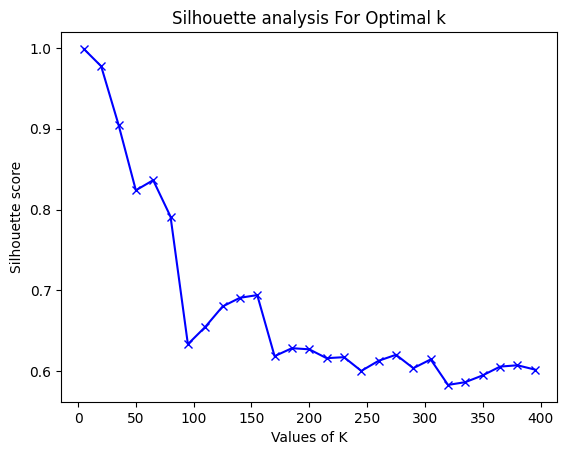

In [44]:
range_n_clusters = range(5,400,15)
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
    birch = Birch(n_clusters=num_clusters)
    birch.fit(X)
    cluster_labels = birch.labels_
    print(num_clusters)
 # silhouette score
    silhouette_avg.append(silhouette_score(X, cluster_labels))
    
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [47]:
birch = Birch(n_clusters=150)
birch.fit(X)
finance_df['label'] = birch.labels_

/var/folders/0b/h0zc244107jg60tttkl4r0kw0000gn/T/ipykernel_10993/4269053702.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finance_df['label'] = birch.labels_


In [ ]:
labels = [35, 1, 108]

In [115]:
finance_df[(finance_df['label'] == 38) & (finance_df['year'] == 2022)][['ticker', 'year', 'year_2', 'mkt_cap_x']]

,ticker,year,year_2,mkt_cap_x


In [91]:
finance_df[finance_df['label'] == 20].sort_values(['mkt_cap_x', 'year'], ascending=False)[['ticker', 'year', 'year_2', 'mkt_cap_x']].to_csv("1.csv")